# Notebook to generate a fake disk, inject it an observation, and try to retrieve it afterwards by smoothing, deprojecting, rescaling


The notebook is organized as follows, in 4 parts: 

#### I. Load an observation

- reduced observation

#### II. Generate a fake disk

#### III. Subtract it from the observation 

- First from the reduced observation, just to get an idea

- Then, from the pre-reduced observation, for different rotating angles

#### IV. Compute the chi squared

#### V. Apply MCMC

Note utiliser:
    
    fake_disk3.print_info()
    

    r**alpha_out 
    alpha_out = -3.5 valeur typique à prendre quand ce n'est pas sharp
    (Voir papier Thébaut (2008). Attention subtilité. Radial surface brightness. Attention)
    
Si alpha_in différent de alpha_out, r0 n'est pas là où il a le maximum de poussières.
Voir e.g. Eq. 3 de Olofsson+2021.



 <font color='red'> **Warning:** </font> 

The version 3 of emcee should be downloaded!



_Written by Célia Desgrange, 2022-11-04. Based on the jupyter notebook **inject_or_recover_a_disk**_ done for HD 95086.

_Contribution: Julien Milli's tutorial using the package vip_hci._

_Revised by Célia:_

_2022-11-07:_ 

- Part I - III first point, done
- Started to implement the MCMC part

_2022-11-22:_ 
- Do it for the polarized imaged: checked input parameters, formulas Olofsson+2022 vs us


_Next time:_
- Add zone on which to compute the cost function
- Look into Johan Mazoyer script on how the MCMC is implemented

        

In [1]:
import glob
import numpy as np
import time, os

from astropy.convolution import (convolve_fft, convolve, Gaussian2DKernel)

import vip_hci as vip
from astropy.io import fits
import cv2

from import_functions_generic import * 
from import_functions_plotting import * 
from image_manipulation import * 

import emcee
print(emcee.__version__)

3.1.3


In [2]:
L = time.localtime()
date = "{}-{}-{}".format(L[0],L[1],L[2],L[3],L[4],L[5])

saving_dir = 'figs/fig_v{}/'.format(date)
os.makedirs(saving_dir,exist_ok=True)

In [157]:
plt.style.use('classic')  
mpl.rc('image', cmap='viridis')#, origin='lower')
#mpl.rc('text', usetex=True)
#mpl.rc(mathtext.fontset = 'stix')


rcParams.update({'font.size': 14,  'axes.labelsize' : 14, 'legend.fontsize' : 12,
"font.family": "serif", 'text.usetex' : True, "font.serif": [], "font.sans-serif": [],
'legend.handlelength': 1.5, 'legend.borderaxespad' : 0.8, 'legend.columnspacing' : 1, 'legend.handletextpad' : 0.5})

rcParams['mathtext.fontset'] = 'stix'

In [3]:
107.4 + 10.4

117.80000000000001

# I. Load an observation

In [4]:
# Initialize the path to the wished data 
# -> supposed to be changed accordingly to the data/computer used
infolder = '/Users/desgranc/Documents/work/projects/HD120326/data/'
folder_prereduced = 'prereduced/convert/'
folder_reduced = 'reduced/'
dF       = pd.read_csv(infolder + 'list_obs.txt',sep='\t')
dF

,target,epoch,instrument,polar,filter,quality,"seeing ("")",tau0 (ms),delta pa (deg),PI,DIT (s),Nb frames,Total exposure (min)
0,HD_120326,2016-04-05,IRDIS,no,H23,good,1.1,3.5,37,Bonnefoy & Ménard,32.0,128.0,68.0
1,HD_120326,2016-06-03,IRDIS,no,H23,good,0.71,3.1,22,Hinkley & Matthews,32.0,80.0,43.0
2,HD_120326,2016-06-13,IRDIS,no,J23,to check,to check,to check,NaN,GTO,NaN,NaN,NaN
3,HD_120326,2018-06-01,IRDIS,yes,BB_H,very good,0.45,4.2,Boccaletti,NaN,NaN,NaN,NaN
4,HD_120326,2019-06-26,IRDIS,no,BB_H,very bad,1.84,2.4,36,Bonnefoy & Ménard,NaN,NaN,NaN
5,HD_120326,2019-07-09,IRDIS,no,BB_H,very good,0.54,3.1,58,Bonnefoy & Ménard,32.0,224.0,119.0
6,HD_120326,2016-04-05,IFS,no,YJ,good,1.1,3.5,37,Bonnefoy & Ménard,64.0,64.0,68.0
7,HD_120326,2016-06-03,IFS,no,YJ,good,0.71,3.1,22,Hinkley & Matthews,64.0,40.0,43.0
8,HD_120326,2019-06-26,IFS,no,YJ,very bad,1.84,2.4,36,Bonnefoy & Ménard,NaN,NaN,NaN
9,HD_120326,2019-07-09,IFS,no,YJ,very good,0.54,3.1,58,Bonnefoy & Ménard,64.0,112.0,119.0


In [139]:
idx, idx_pcs, before_or_after,sorting = 3, 10, 'after', 'softsorting'
epoch = str(dF['epoch'].iloc[idx])
print('Load the epoch: {}'.format(epoch))
algo = 'PCA_Celia/'
path_im_reduced = infolder + folder_reduced + algo + '*fits/*{}*{}*{}_cube_im_pca.fits'.format(epoch,before_or_after,sorting)
obs_polar = str(dF['polar'].iloc[idx])
norm_flux = 1

if obs_polar == 'yes': 
    print('(!) polarized light')
    algo = 'IRDAP/'
    path_im_reduced = infolder + folder_reduced + algo + '{}/reduced_pdi/star_pol*/*Q_phi*.fits'.format(epoch)
    norm_flux = 273034240.123101 # to convert in contrast
        
print('It corresponds do the path:\n{}'.format(path_im_reduced))
print('\nFiles found:')
flist = glob(path_im_reduced)
for f in flist: print('-',f)
im_reduced = fits.getdata(flist[0])

if obs_polar == 'no': im_reduced=im_reduced[idx_pcs]

Load the epoch: 2018-06-01
(!) polarized light
It corresponds do the path:
/Users/desgranc/Documents/work/projects/HD120326/data/reduced/IRDAP/2018-06-01/reduced_pdi/star_pol*/*Q_phi*.fits

Files found:
- /Users/desgranc/Documents/work/projects/HD120326/data/reduced/IRDAP/2018-06-01/reduced_pdi/star_pol_subtr/HIP67497_2018-06-02_Q_phi_star_pol_subtr.fits


# Parameters: generic

In [233]:
# Disk - system
if obs_polar == 'true' or 1: # take values from Olofsson+2022
    itilt_ref = 180-76.7 # inclination of your disk in degrees
    pa_ref = 86.4    # position angle of the disk in degrees (from north to east)
    a_ref  = 0.31    # semimajoraxis of the disk in au
    g_ref  = 0.82    # (!) no value in Olofsson+2022, value from Bonnefoy+2017
    flux_ref = 1     # (!)
    dstar = 113.27   # distance to the star in pc, lower/upper limits: 98.7-117.8 (van Leeuwen 2007)
    ain_ref = 12
    aou_ref = -1.9

    itilt_ref_err, pa_ref_err, a_ref_err, g_ref_err, dstar_ref_err = 0.6, 0.7, 0.03, 0.02, 0.38
    a_ref, a_ref_err = a_ref*dstar, a_ref_err*dstar
    ain_ref_err, aout_ref_err,  = 3.9, 0.1
    
    phi_ref, phi_ref_err = 0.005, 0.002
    ksi0_ref, ksi0_ref_err = phi_ref*a_ref, a_ref*phi_ref_err+a_ref_err*phi_ref
    print('Olfsson et al. 2022 compute tan(phi) = ksi0/a0 which corresponds to ksi0 = {:.2f} +/- {:.2f} au.'.format(ksi0_ref, ksi0_ref_err))
    
    im_crop_obs = 450

elif obs_polar == 'no' : # take values from Bonnefoy+2017
    itilt_ref = 80 # inclination of your disk in degrees
    pa_ref = -93   # position angle of the disk in degrees (from north to east)
    a_ref  = 58.6  # semimajoraxis of the disk in au
    g_ref  = 0.82
    flux_ref = 1   # (!)
    dstar = 107.4  # distance to the star in pc, lower/upper limits: 98.7-117.8 (van Leeuwen 2007)

    itilt_err, pa_err, a_err, g_err, dstar_err = 1, 1, 3, 0.02, 10
    ain_ref, aout_ref = 10, -5 # fixed
    
    im_crop_obs = 250

# Image - observation
pixel_scale=0.01225 # pixel scale in arcsec/px 
platescale = pixel_scale*1e3
scalebar_pix, scalebar_leg = 1000, '1"'
nx, ny = np.shape(im) # number of pixels of your image in X
#ny = 624 # number of pixels of your image in Y

# Save file .fits
writeto = False # save .fits file

# Figure
im_crop =  im_crop_obs#  250
save_png = 0    # save .png file
right, cbar_xdeb = 0.78, 0.83
scalebar_pix, scalebar_leg = 100, '0.1"'

Olfsson et al. 2022 compute tan(phi) = ksi0/a0 which corresponds to ksi0 = 0.18 +/- 0.09 au.


In [106]:
ny

1024

The file is saved here:
 figs/fig_v2023-3-6/im_obs_reduced_IRDAP_2018-06-01


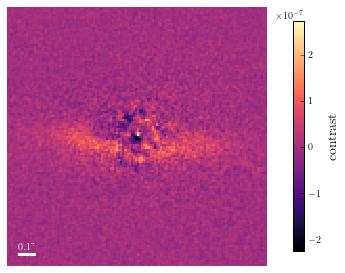

In [140]:
algoo = algo.replace('/','')

namesave = 'im_obs_reduced_{}_{}'.format(algoo, epoch)
im = im_reduced / norm_flux
clab = 'contrast'
vmin, vmax = None, None
plot_fig(im=im, clab=clab, vmin=vmin, vmax=vmax, im_crop=im_crop_obs, scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, 
         platescale=platescale, cbar_xdeb=cbar_xdeb, right=right, saving_dir=saving_dir, namesave=namesave)

# II. Generate a fake disk
### Disk properties

In [74]:
itilt = itilt_ref # inclination of your disk in degrees
pa= pa_ref # position angle of the disk in degrees (from north to east)
a = a_ref # semimajoraxis of the disk in au
ain, aout = ain_ref, aou_ref # inner edge, outer edge
g = g_ref
flux = flux_ref

In [75]:
help(plot_fig)

Help on function plot_fig in module import_functions_plotting:

plot_fig(im, clab='', vmin=None, vmax=None, text='None', text_xfrac=0.03, text_yfrac=0.9, show_axis_ticks='off', im_crop=0, scalebar_pix=100, scalebar_leg='100 mas', platescale=12.25, add_colorbar=1, cbar_xdeb=0.82, right=0.8, top=0.95, left=0.01, bottom=0.05, figsize=(5, 4), interpolation='nearest', saving_dir='', namesave='test', save_png=0, cmap='magma')



### Different type of disks

(Based on Julien Milli's tutorial with the vip_hci package, public)


#### 1. Let's try a pole-on symmetric diks without anisotropy of scattering

In [109]:
fake_disk1 = vip.fm.scattered_light_disk.ScatteredLightDisk(\
                        nx=nx,ny=ny,distance=dstar,\
                        itilt=0,omega=0,pxInArcsec=pixel_scale,pa=pa,\
                        density_dico={'name':'2PowerLaws','ain':ain,'aout':aout,\
                        'a':a,'e':0.0,'ksi0':1.,'gamma':2.,'beta':1.},\
                        spf_dico={'name':'HG', 'g':0., 'polar':False},flux_max=1)
fake_disk1_map = fake_disk1.compute_scattered_light()

The file is saved here:
 figs/fig_v2023-3-6/fake_disk1_map_unit_arbitrary


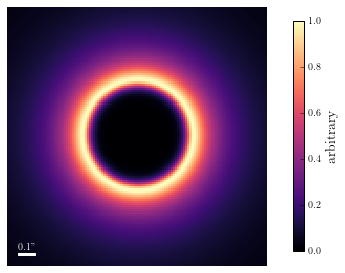

In [112]:
namesave = 'fake_disk1_map_unit_arbitrary'
im = fake_disk1_map
clab = 'arbitrary'
vmin, vmax = None, None#-10, 10
plot_fig(im=im, clab=clab, vmin=vmin, vmax=vmax, im_crop=im_crop, saving_dir=saving_dir, namesave=namesave,
        scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, platescale=platescale, cbar_xdeb=cbar_xdeb, 
         right=right )

#### 2. Let's incline it by itilt degree

In [113]:
fake_disk2 = vip.fm.scattered_light_disk.ScatteredLightDisk(\
                        nx=nx,ny=ny,distance=dstar,\
                        itilt=itilt,omega=0,pxInArcsec=pixel_scale,pa=pa,\
                        density_dico={'name':'2PowerLaws','ain':ain,'aout':aout,\
                        'a':a,'e':0.0,'ksi0':1.,'gamma':2.,'beta':1.},\
                        spf_dico={'name':'HG', 'g':0., 'polar':False},flux_max=1)
fake_disk2_map = fake_disk2.compute_scattered_light()

The file is saved here:
 figs/fig_v2023-3-6/fake_disk2_map_unit_arbitrary


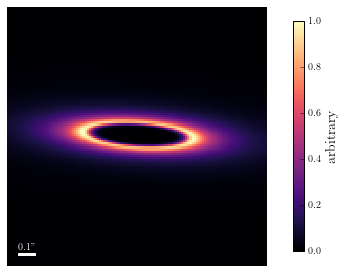

In [114]:
namesave = 'fake_disk2_map_unit_arbitrary'
im = fake_disk2_map
clab = 'arbitrary'
vmin, vmax = None, None#-10, 10
plot_fig(im=im, clab=clab, vmin=vmin, vmax=vmax, im_crop=im_crop, saving_dir=saving_dir, namesave=namesave,
        scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, platescale=platescale, cbar_xdeb=cbar_xdeb,
        right=right)

#### 3. Let's change the scattering phase function and add some anisotropy of scattering

In [231]:
g=0.4
fake_disk3 = vip.fm.scattered_light_disk.ScatteredLightDisk(\
                        nx=nx,ny=ny,distance=dstar,\
                        itilt=180-itilt,omega=0,pxInArcsec=pixel_scale,pa=pa,\
                        density_dico={'name':'2PowerLaws','ain':ain,'aout':aout,\
                        'a':a,'e':0.0,'ksi0':1.,'gamma':2.,'beta':1.},\
                        spf_dico={'name':'HG', 'g':g, 'polar':False},flux_max=1)
fake_disk3_map = fake_disk3.compute_scattered_light()

The file is saved here:
 figs/fig_v2023-3-6/fake_disk3_map_unit_arbitrary


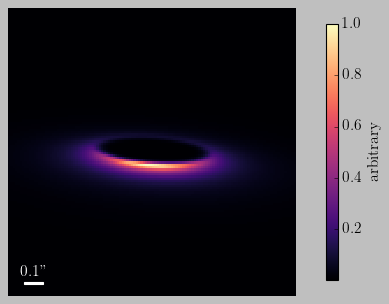

In [232]:
namesave = 'fake_disk3_map_unit_arbitrary'
im = fake_disk3_map
clab = 'arbitrary'
vmin, vmax = None, None#-10, 10
vmin, vmax = 1e-3, 1#-10, 10
plot_fig(im=im, clab=clab, vmin=vmin, vmax=vmax, im_crop=im_crop, saving_dir=saving_dir, namesave=namesave,
        scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, platescale=platescale, cbar_xdeb=cbar_xdeb, 
        right=right # norm=colors.LogNorm()
        )

if writeto: fits.writeto(saving_dir+namesave+'.fits', im, overwrite=True)

In [117]:
#fake_disk3.print_info()

In [173]:
im_crop

450

In [148]:
print(itilt_ref)
print(pa)
print(a_ref)
print(g_ref)
print(flux)

76.7
86.4
35.1137
0.82
1


#### 4. Let's change the scattering phase function and add some backward scattering

In [119]:
fake_disk4 = vip.fm.scattered_light_disk.ScatteredLightDisk(\
                        nx=nx,ny=ny,distance=dstar,\
                        itilt=itilt,omega=0,pxInArcsec=pixel_scale,pa=pa,\
                        density_dico={'name':'2PowerLaws','ain':ain,'aout':aout,\
                        'a':a,'e':0.0,'ksi0':1.,'gamma':2.,'beta':1.},\
                        spf_dico={'name':'DoubleHG','g':[0.6,-0.6],'weight':0.7,\
                                  'polar':False},flux_max=1)
fake_disk4_map = fake_disk4.compute_scattered_light()

The file is saved here:
 figs/fig_v2023-3-6/fake_disk4_map_unit_arbitrary


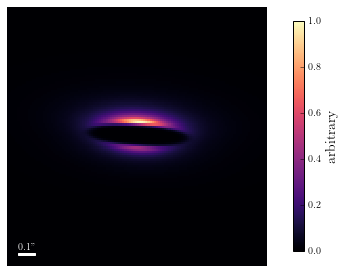

In [120]:
namesave = 'fake_disk4_map_unit_arbitrary'
im = fake_disk4_map
clab = 'arbitrary'
vmin, vmax = None, None#-10, 10
plot_fig(im=im, clab=clab, vmin=vmin, vmax=vmax, im_crop=im_crop, saving_dir=saving_dir, namesave=namesave,
        scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, platescale=platescale, cbar_xdeb=cbar_xdeb, 
        right=right)

#### 5. Let's plug in the Rayleigh scattering in polarimetry

In [121]:
print("Create a fake disk with Rayleigh scattering")
fake_disk5 = vip.fm.scattered_light_disk.ScatteredLightDisk(\
                        nx=nx,ny=ny,distance=dstar,\
                        itilt=itilt,omega=0,pxInArcsec=pixel_scale,pa=pa,\
                        density_dico={'name':'2PowerLaws','ain':ain,'aout':aout,\
                        'a':a,'e':0.0,'ksi0':1.,'gamma':2.,'beta':1.},\
                        spf_dico={'name':'DoubleHG','g':[0.6,-0.6],'weight':0.7,\
                                  'polar':True},flux_max=1)
fake_disk5_map = fake_disk5.compute_scattered_light()

Create a fake disk with Rayleigh scattering


The file is saved here:
 figs/fig_v2023-3-6/fake_disk5_map_unit_arbitrary


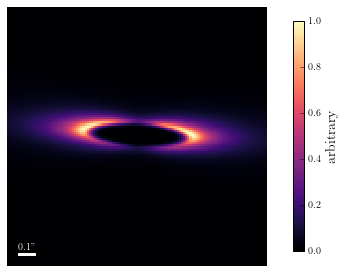

In [122]:
namesave = 'fake_disk5_map_unit_arbitrary'
im = fake_disk5_map
clab = 'arbitrary'
vmin, vmax = None, None#-10, 10
plot_fig(im=im, clab=clab, vmin=vmin, vmax=vmax, im_crop=im_crop, saving_dir=saving_dir, namesave=namesave,
        scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, platescale=platescale, cbar_xdeb=cbar_xdeb, 
        right=right)

##  Prepare to inject the fake disk in the empty observation
### Select the fake disk

In [186]:
fake_disk_map = fake_disk3_map

### Convolve the fake disk with the PSF

#### Generate the PSF

The file is saved here:
 psf


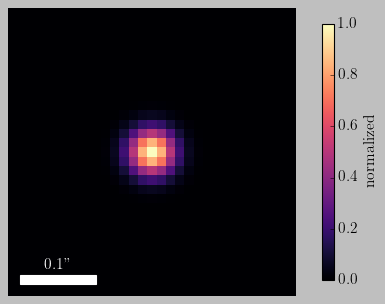

In [187]:
w, D, platescale = 1.625e-6, 8, 12.25
fwhm_psf = fwhm(w, D, platescale, unit='pixel')
psf = generate_kernel(fwhm=fwhm_psf) # maximal value of the psf=1
plot_fig(psf,clab='normalized',namesave='psf',
        scalebar_leg='0.1"', platescale=platescale, cbar_xdeb=cbar_xdeb)

#### Convolve the disk with the instrument expected PSF

In [188]:
writeto=False

The file is saved here:
 figs/fig_v2023-3-6/fake_disk_convolved_unit=arbitrary_ain=12_aout=-1.9


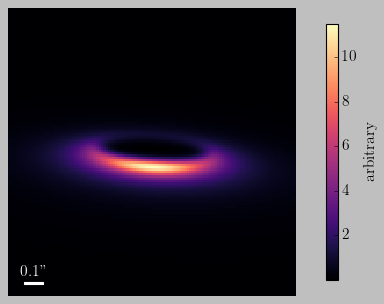

In [189]:
fake_disk_map_convolved = convolve_fft(fake_disk_map, psf, normalize_kernel=False, nan_treatment='fill')

namesave = 'fake_disk_convolved_unit=arbitrary_ain={}_aout={}'.format(ain, aout)
im = fake_disk_map_convolved
clab = 'arbitrary'
vmin, vmax = None, None#-10, 10
plot_fig(im=im, clab=clab, vmin=vmin, vmax=vmax, im_crop=im_crop, saving_dir=saving_dir, namesave=namesave,
        scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, platescale=platescale, cbar_xdeb=cbar_xdeb,
        right=right)

if writeto: fits.writeto(saving_dir+namesave+'.fits', fake_disk_map, overwrite=True)

### Convert it in contrast unit

The file is saved here:
 figs/fig_v2023-3-6/im_fake_disk_convolved_contrast_inj=1.0e+00_ain=12_aout=-1.9


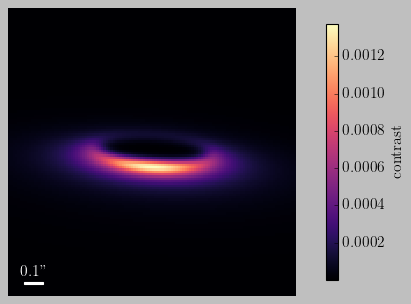

In [190]:
## Give it a contrast of...
contrast_injection = 1
norm_disk = np.nansum(fake_disk_map_convolved)
normalization_factor = contrast_injection / norm_disk 
fake_disk_map_convolved_contrast =  fake_disk_map_convolved * normalization_factor

# Display Figure
im = fake_disk_map_convolved_contrast
clab = 'contrast'
vmin, vmax = None, None
namesave = "im_fake_disk_convolved_contrast_inj={:.1e}_ain={}_aout={}".format(contrast_injection, ain, aout)
plot_fig(im=im, clab=clab, vmin=vmin, vmax=vmax, im_crop=im_crop, saving_dir=saving_dir, namesave=namesave,
        scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, platescale=platescale, cbar_xdeb=cbar_xdeb,
        right=right)

if writeto : fits.writeto(saving_dir+namesave+'.fits', fake_disk_map_convolved_contrast, overwrite=True)

In [191]:
print('The sum of the generated fake disk is equal to {:.1e}.'.format(np.nansum(fake_disk_map_convolved_contrast)))

The sum of the generated fake disk is equal to 1.0e+00.


In [192]:
print('The max of the generated fake disk is equal to {:.1e}.'.format(np.nanmax(fake_disk_map_convolved_contrast)))

The max of the generated fake disk is equal to 1.4e-03.


# III. Subtraction of the fake disk in the observation

## In the reduced observation

The file is saved here:
 figs/fig_v2023-3-6/im_fake_obs_contrast_inj=1.0e+00_ain=12_aout=-1.9


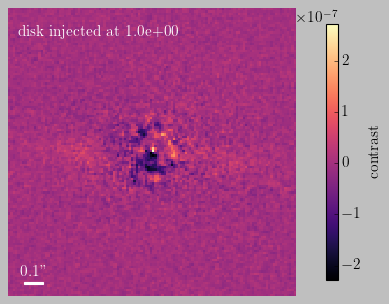

In [203]:
## Injection!

im_subtr = im_reduced/norm_flux - fake_disk_map_convolved_contrast*1e-4

# Display Figure
im = im_subtr
clab = 'contrast'
vmin, vmax = None, None #-2e-7, 2e-7 #None#-10, 10
text = 'disk injected at {:.1e}'.format(contrast_injection)
namesave = "im_fake_obs_contrast_inj={:.1e}_ain={}_aout={}".format(contrast_injection, ain, aout)
plot_fig(im=im, clab=clab, vmin=vmin, vmax=vmax, text=text, saving_dir=saving_dir, namesave=namesave, im_crop=im_crop,
        scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, platescale=platescale, cbar_xdeb=cbar_xdeb, right=right)

if writeto: fits.writeto(saving_dir+namesave+'.fits', im_finale, overwrite=True)


The file is saved here:
 figs/fig_v2023-3-6/mosaic_HD120326_2018-06-01


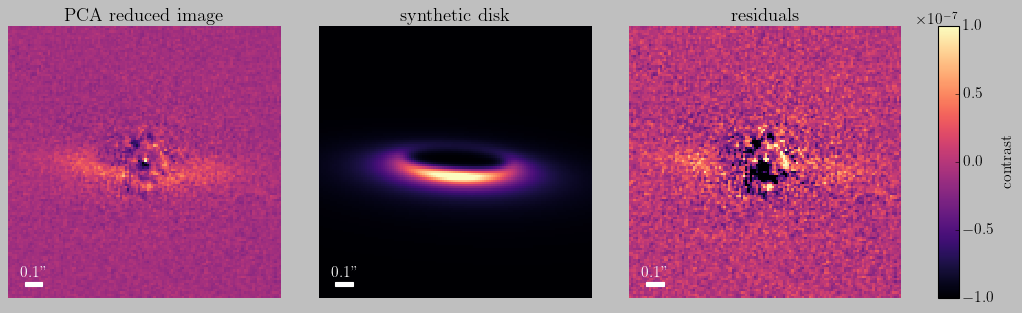

In [215]:
# Display figures
im_subtr = im_reduced/norm_flux - fake_disk_map_convolved_contrast*1e-4#8e-5
fake_disk_map[fake_disk_map==0] = 1e-12 
IM = [im_reduced, fake_disk_map_convolved, im_subtr]
TIT = ['PCA reduced image', 'synthetic disk', 'residuals']
namesave = "mosaic_HD120326_{}".format(epoch)
NORMS = [None,colors.LogNorm(),None]
add_specific_vminmax = 1
add_specific_norms = 1
vmin_obs, vmax_obs = -1e-7,1e-7 
vmin, vmax = [None, 1e-5, vmin_obs], [None, 10, vmax_obs] #[vmin_obs, 1e-2, vmin_obs], [vmax_obs, 1, vmax_obs]

plot_figs_1row(IM, TIT, show_axis_ticks='off', vmin=vmin, vmax=vmax, clab='contrast', 
               add_text=0, text=text,
               wspace=0.02, right=0.9, cbar_xdeb=0.92, cbar_xwidth=0.02, top=0.9, im_crop=im_crop, 
               scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, platescale=platescale,
               saving_dir=saving_dir, namesave=namesave, 
              add_specific_vminmax=add_specific_vminmax,  add_specific_norms=add_specific_norms, norm=NORMS)#, cmap=cmap)

# IV. Compute the chi squared

    likelihood = exp (- chi**2/2)

# V. MCMC

## Disk - 1 ring

Free parameters:

    itilt = itilt_ref # inclination of your disk in degrees
    pa= pa_ref # position angle of the disk in degrees (from north to east)
    a = a_ref # semimajoraxis of the disk in au
    g = g_ref
    flux = flux_ref
    
Fixed parameters:

     ain, aout = ain_ref, aout_ref # inner edge, outer edge

In [51]:
print(ain, aout)

10 -5


In [52]:
print(nx, ny)

624 624


### Function 

In [216]:
labs = ['a (au)', 'inc (°)', 'PA (°)',  'g', 'flux']

In [217]:
def call_gen_disk(theta):
    """ call the disk model from a set of parameters. 2g SPF
        use DIMENSION, PIXSCALE_INS and DISTANCE_STAR

    Args:
        theta: list of parameters of the MCMC

    Returns:
        a 2d model
    """
    r1 = mt.exp(theta[0])
    inc = theta[1] #np.degrees(np.arccos(theta[3]))
    pa  = theta[2]
    g   = theta[3]
    norm = theta[4] # flux
    
    # fixed
    ain =  10
    aout = -5 
    argperi = 0
    eccentricity = 0  # de préférence: =0 car très ad hoc, plutôt privilégier le décalage de l'étoile.
    ksi0 = 1

    #generate the model
    model = vip.fm.scattered_light_disk.ScatteredLightDisk(
                               nx=DIMENSION,
                               ny=DIMENSION,
                               distance=DISTANCE_STAR,
                               itilt=inc,
                               omega=argperi,
                               pxInArcsec=PIXSCALE_INS,
                               pa=pa,
                               flux_max=norm,
                               density_dico={
                                   'name': '2PowerLaws',
                                   'ain': ain,
                                   'aout': aout,
                                   'a': r1,
                                   'e': eccentricity,
                                   'ksi0': ksi0, # olofsson: tan phi = ksi0/r0. 
                                   'gamma': 2., # gamma = 2 gaussien cf Eq 2 de Olofsson+2021, ou papier Milli+2017
                                   # gamma faible : echelle hauteur très étalée, gamma grand: disque très piqué/compact
                                   'beta': 1. # beta=1, flairing = linéaire #olofsson n'a pas de beta
                               },
                               spf_dico={
                                   'name': 'HG',
                                   'g': g,
                                   'polar': False
                               })
    return model.compute_scattered_light()


### Functions density

In [218]:
from astropy.convolution import convolve

def logl(theta):
    """ measure the Chisquare (log of the likelihood) of the parameter set.
        create disk
        convolve by the PSF (psf is global)
        do the forward modeling (diskFM obj is global)
        nan out when it is out of the zone (zone mask is global)
        subctract from data and divide by noise (data and noise are global)

    Args:
        theta: list of parameters of the MCMC

    Returns:
        Chisquare
    """

    model = call_gen_disk(theta)

    modelconvolved = convolve(model, PSF, boundary='wrap')
    DISKOBJ.update_disk(modelconvolved)
    model_fm = DISKOBJ.fm_parallelized()[0]

    # reduced data have already been naned outside of the minimization
    # zone, so we don't need to do it also for model_fm
    res = (REDUCED_DATA - model_fm) / NOISE

    Chisquare = np.nansum(-0.5 * (res * res))

    return Chisquare

In [219]:

########################################################
def logp(theta):
    """ measure the log of the priors of the parameter set.

    Args:
        theta: list of parameters of the MCMC

    Returns:
        log of priors
    """

    r1 = mt.exp(theta[0])
    ain = theta[1]
    aout = theta[2]
    inc = np.degrees(np.arccos(theta[3]))
    pa = theta[4]

    argperi = theta[5]
    eccentricity = theta[6]
    ksi0 = theta[7]

    g1 = theta[8]
    g2 = theta[9]
    alpha = theta[10]

    norm = mt.exp(theta[11])

    if (r1 < 20 or r1 > 130):  #Can't be bigger than 200 AU
        return -np.inf

    if (ain < 1 or aout > 30):
        return -np.inf

    if (aout < -30 or aout > -1):
        return -np.inf

    if (inc < 0 or inc > 90):
        return -np.inf

    if (pa < 0 or pa > 180):
        return -np.inf

    if (argperi < 0 or argperi > 180):
        return -np.inf

    if (eccentricity < 0 or eccentricity > 1):
        return -np.inf

    if (ksi0 < 0.1 or ksi0 > 10):  #The aspect ratio
        return -np.inf

    if (g1 < 0.05 or g1 > 0.9999):
        return -np.inf

    if (g2 < -0.9999 or g2 > -0.05):
        return -np.inf

    if (alpha < 0.01 or alpha > 0.9999):
        return -np.inf

    if (norm < 0.5 or norm > 50000):
        return -np.inf
    # otherwise ...

    return 0.0 # 100 % log 1 = 0

In [220]:
def lnpb(theta):
    """ sum the logs of the priors (return of the logp function)
        and of the likelihood (return of the logl function)


    Args:
        theta: list of parameters of the MCMC

    Returns:
        log of priors + log of likelyhood
    """
    # from datetime import datetime
    # starttime=datetime.now()
    lp = logp(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = logl(theta)
    # print("Running time model + FM: ", datetime.now()-starttime)

    return lp + ll


In [221]:
help(np.linalg.solve)

Help on function solve in module numpy.linalg:

solve(a, b)
    Solve a linear matrix equation, or system of linear scalar equations.
    
    Computes the "exact" solution, `x`, of the well-determined, i.e., full
    rank, linear matrix equation `ax = b`.
    
    Parameters
    ----------
    a : (..., M, M) array_like
        Coefficient matrix.
    b : {(..., M,), (..., M, K)}, array_like
        Ordinate or "dependent variable" values.
    
    Returns
    -------
    x : {(..., M,), (..., M, K)} ndarray
        Solution to the system a x = b.  Returned shape is identical to `b`.
    
    Raises
    ------
    LinAlgError
        If `a` is singular or not square.
    
    See Also
    --------
    scipy.linalg.solve : Similar function in SciPy.
    
    Notes
    -----
    
    .. versionadded:: 1.8.0
    
    Broadcasting rules apply, see the `numpy.linalg` documentation for
    details.
    
    The solutions are computed using LAPACK routine ``_gesv``.
    
    `a` must be squa

In [222]:
##

def plot_samples_1row(Y, TIT=['',''], clab='', vmin=None, vmax=None, add_text=0, text=['',''], scalebar_pix=100, scalebar_leg='100 mas', platescale=12.25,
                    right=0.95, top=0.95, left=0.12, bottom=0.12, wspace=0,
                   figsize_height=4, figsize=(None,None), cmap='magma', norm=None,
                    xlab='', ylab='',
                    add_leg=1, loc=0, frameon=False, ncol=1,
                    im_crop=0, interpolation='nearest', saving_dir='', namesave='test', save_png=0):
    nco = len(Y[0])
    print(figsize, figsize==(None,None),)
    figsize = tuple(np.where(figsize==(None,None), (figsize_height*nco,figsize_height), figsize))
   
    fig, axs = plt.subplots(1,nco, figsize=figsize, sharey=True)
    fig.subplots_adjust(left=left, right=right, top=top, bottom=bottom, wspace=wspace)
    
    axs[0].set_xlabel(ylab)
    for i in range(nco):
        ax = axs[i]
        tit = TIT[i]; ax.set_title(tit); ax.set_xlabel(xlab[i])
        
        ax.hist(Y[:, i], 100, color="k", histtype="step", label='mean={:.2f}\n$\sigma$={:.2f}'.format(np.nanmean(Y[:,i]),np.nanstd(Y[:,i])))
        
        # Add text
        if add_text:
            # One same text to add on every subimage
            if len(text[0]) == 1: ax.text(1,h*0.9,text,color='black')
            # Different texts to add on every subimages
            else: ax.text(w*0.03,h*0.94,text[i],color='black')
                
        if add_leg:
            ax.legend(loc=loc, frameon=frameon, ncol=ncol)
        mise_en_page(ax)

    print('The file is saved here:\n', saving_dir+namesave)
    plt.savefig(saving_dir+namesave+'.pdf')
    if save_png: plt.savefig(saving_dir+namesave+'.png', dpi=200)
    plt.show()


### Parameters:

5 free parameters:
- r0
- position angle
- inclination 
- g
- flux

2 fixed parameters (try with them free?)
- alpha_in
- alpha_out?

In [223]:
np.random.seed(42)
means = np.array([a_ref, pa_ref, itilt_ref, g_ref, flux_ref])
labs = ['a (au)', 'PA (°)', 'inc (°)', 'g', 'flux']

ndim = len(means)

print('A priori mean of the free parameters:\na_ref, pa_ref, itilt_ref, g_ref, flux_ref\n{}'.format(means))

# Generate a squared matrix 
cov = means - np.random.rand(ndim**2).reshape((ndim, ndim))
# Define an upper trigonal matrix
cov = np.triu(cov) 
# We want one symmetrical covariance matrix, and with the diagonal counted once
cov += cov.T - np.diag(cov.diagonal()) 
# We want to multiply the two matrices
cov = np.dot(cov, cov)
cov

A priori mean of the free parameters:
a_ref, pa_ref, itilt_ref, g_ref, flux_ref
[35.1137 86.4    76.7     0.82    1.    ]


array([[1.42802889e+04, 1.61075307e+04, 1.48833429e+04, 7.32396524e+01,
        1.17035266e+02],
       [1.61075307e+04, 2.05074089e+04, 1.87927484e+04, 8.41855217e+01,
        1.59682446e+02],
       [1.48833429e+04, 1.87927484e+04, 1.72788317e+04, 8.03312111e+01,
        1.49202217e+02],
       [7.32396524e+01, 8.41855217e+01, 8.03312111e+01, 1.11909726e+00,
        1.40844342e+00],
       [1.17035266e+02, 1.59682446e+02, 1.49202217e+02, 1.40844342e+00,
        2.26515253e+00]])

In [224]:
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)
#p0

In [227]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpb, 
            args=[means, cov])

In [228]:
#log_prob(p0[0], means, cov)

In [229]:
# Apply burn-in factor
state = sampler.run_mcmc(p0, 100)
sampler.reset()

emcee: Exception while calling your likelihood function:
  params: [0.78517596 0.19967378 0.51423444 0.59241457 0.04645041]
  args: [array([35.1137, 86.4   , 76.7   ,  0.82  ,  1.    ]), array([[1.42802889e+04, 1.61075307e+04, 1.48833429e+04, 7.32396524e+01,
        1.17035266e+02],
       [1.61075307e+04, 2.05074089e+04, 1.87927484e+04, 8.41855217e+01,
        1.59682446e+02],
       [1.48833429e+04, 1.87927484e+04, 1.72788317e+04, 8.03312111e+01,
        1.49202217e+02],
       [7.32396524e+01, 8.41855217e+01, 8.03312111e+01, 1.11909726e+00,
        1.40844342e+00],
       [1.17035266e+02, 1.59682446e+02, 1.49202217e+02, 1.40844342e+00,
        2.26515253e+00]])]
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/desgranc/opt/anaconda3/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
TypeError: lnpb() takes 1 positional argument but 3 were given


TypeError: lnpb() takes 1 positional argument but 3 were given

In [230]:
final = sampler.run_mcmc(state, 10000)

NameError: name 'state' is not defined

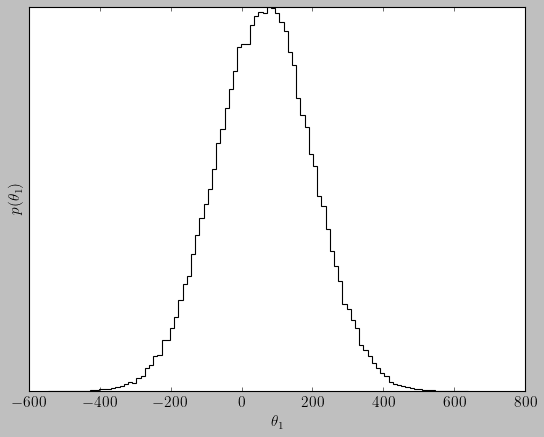

In [28]:
# Figure
#fig, ax = 
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

(16, 3.5) False
The file is saved here:
 figs/fig_v2022-11-8/mcmc_samples


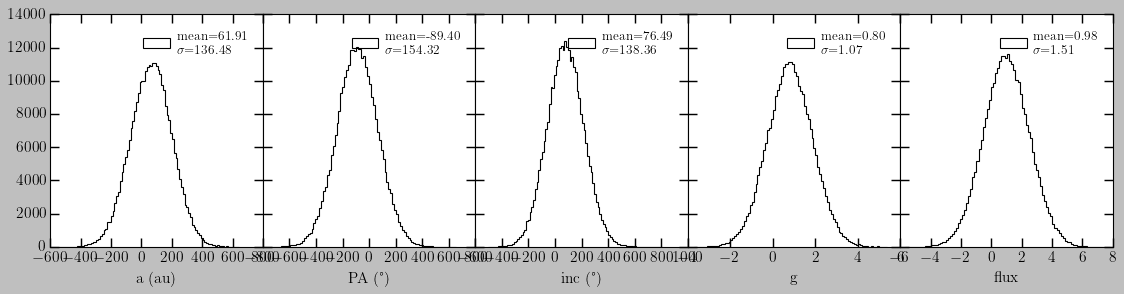

In [29]:
# Figure
namesave = 'mcmc_samples'
xlab, ylab = labs, '$p(\theta_1)$'
figsize = (16,3.5)
plot_samples_1row(samples, TIT=['']*10, wspace=0, ylab=ylab, xlab=xlab, figsize=figsize, saving_dir=saving_dir, namesave=namesave)

In [32]:
help(emcee.backends.backend)

Help on module emcee.backends.backend in emcee.backends:

NAME
    emcee.backends.backend - # -*- coding: utf-8 -*-

CLASSES
    builtins.object
        Backend
    
    class Backend(builtins.object)
     |  Backend(dtype=None)
     |  
     |  A simple default backend that stores the chain in memory
     |  
     |  Methods defined here:
     |  
     |  __enter__(self)
     |  
     |  __exit__(self, exception_type, exception_value, traceback)
     |  
     |  __init__(self, dtype=None)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  get_autocorr_time(self, discard=0, thin=1, **kwargs)
     |      Compute an estimate of the autocorrelation time for each parameter
     |      
     |      Args:
     |          thin (Optional[int]): Use only every ``thin`` steps from the
     |              chain. The returned estimate is multiplied by ``thin`` so the
     |              estimated time is in units of steps, not thinned steps.
     |         

# VI. Others

## Azimuthal mean

Note: center convention

    IRDAP: the center of the image is between the four central pixels (even) or the central pixel (odd).
    VIP: the center of the image is supposed at n//2 (located over a pixel in even and odd size image)

In [316]:
recenter = 1
im_shift_center = -0.5

In [317]:
rin = au2sep(106,dstar)
rout = au2sep(320,dstar)
print('The belt is located between 106 and 320 au i.e. {:.1f} and {:.1f} arcseconds.'.format(rin,rout))

The belt is located between 106 and 320 au i.e. 1.0 and 3.0 arcseconds.


In [319]:
# The azimuthal profile is computed every 'sep' pixels
k = 0; sep= 10
im = im_reduced
#im[im<0]=0

# Recenter the image
if recenter: im = vip.preproc.recentering.frame_shift(im, shift_y=im_shift_center, shift_x=im_shift_center)

# Compute the average radius profile
dF1 = vip.stats.im_stats.frame_average_radprofile(im,plot=False,sep=sep) 
dF1.head()

,rad,radprof,npx
0,1,1.109280e-08,8
1,11,-9.567557e-08,64
2,21,-3.534361e-08,144
3,31,-1.176066e-08,208
4,41,-3.948789e-09,272


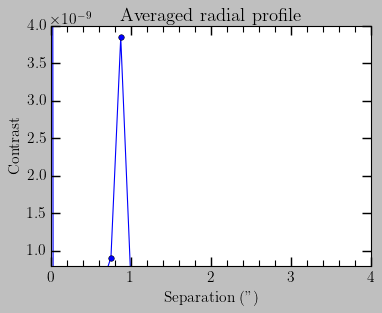

In [326]:
sep1 = np.array(dF1['rad'])*pixel_scale
contrast1 = np.array(dF1['radprof'])

#sep2 = np.array(dF2['rad'])*pixel_scale
#contrast2 = np.array(dF2['radprof'])

xlab, ylab = 'Separation (")', 'Contrast'
tit = 'Averaged radial profile'

ylog=0; #ylim=[0.8e-9, 4e-9]; xlim = [0,4]

fig, ax = plt.subplots(1,1, figsize=(5,4))
fig.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)
fais_moi_un_subplot(ax, sep1, contrast1, ls='-', #lab=LAB[0], 
                    xlim=xlim, ylim=ylim, labx=xlab, laby=ylab, tit=tit, ylog=ylog, 
                    mkr='o', siz=5, lw=1#, c=COLOR[0]
                   )
#fais_moi_un_subplot(ax, sep2, contrast2, ls='-', lab=LAB[1], xlim=xlim, ylim=ylim, labx=xlab, laby=ylab, tit=tit, ylog=ylog, 
#                    mkr='d', siz=5, lw=1, c=COLOR[1], leg=1)
mise_en_page(ax, x_min_step=0.2, x_maj_step=1, x_step=1, y_step=0)

namesave = 'HD120326_{}_radial_profile'.format(epoch)
plt.savefig(saving_dir+namesave+'.pdf')
#plt.plot(sep,contrast)

S'il y a un disque, il est très faible! 

# Bin:

A priori functions below not useful for this notebook or deprecated (i.e. new version exist) -- but still backup, we never know.

In [55]:
# A few useful functions
def fwhm(w=1.6e-6, D=8, platescale=12.25, unit='mas'):
    '''
    Returns the FWHM in mas or pixel (depending on 'unit' value).

    Inputs:
        (optional)
        'w' (type=float): wavelength (unit: m)
            Default: 1.6e-6
        'D' (type=float): telescope diameter (unit: m)
            Default: 8
        'platescale' (type=float): mas/pixel
            Default: 12.25 mas/pix
        'unit' (type=string): unit in which the FWHM is returned
    Output:
        fwhm (type=float/int): float if the unit is mas, int if the unit is pixel.
    '''
    if unit == 'mas' : return w/D*180/np.pi*3600*1e3
    else : return w/D*180/np.pi*3600*1e3//platescale

def gauss2d(x=0, y=0, mx=0, my=0, sx=2, sy=2):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

def generate_kernel(fwhm=40,n=31):
    end = n//2
    x = np.linspace(-end, end, n)
    y = np.linspace(-end, end, n)
    x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
    kernel = gauss2d(x, y, sx=fwhm/2.355, sy=fwhm/2.355)
    return kernel/np.nanmax(kernel) # return a kernel for which the maximal value is equal to 1


In [202]:
# Functions
def deproj_y(im, itilt, pa=0):
    print('Rescale : assumption: the semi-minor axis should be assumed to be on the x-axis (horizontal)')
    ##plot_fig(rotated_frame, clab='arbitrary')
    #im = rotated_frame
    # rotated_frame = im
    nx, ny = np.shape(im)
    if pa != 0:
        im = vip.preproc.frame_rotate(im,-pa,imlib='opencv',cxy=[ny/2,nx/2])
        
    rescale = 1/np.cos(np.deg2rad(itilt))
    new_y = int(im.shape[0] * rescale)
    dim = (rotated_frame.shape[0],new_y)
    # resize image
    vertical_center = int(np.round(ny/2*rescale))
    resized = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)[vertical_center-ny//2:vertical_center+ny//2,:]
    return resized


# Display parameter gamma 

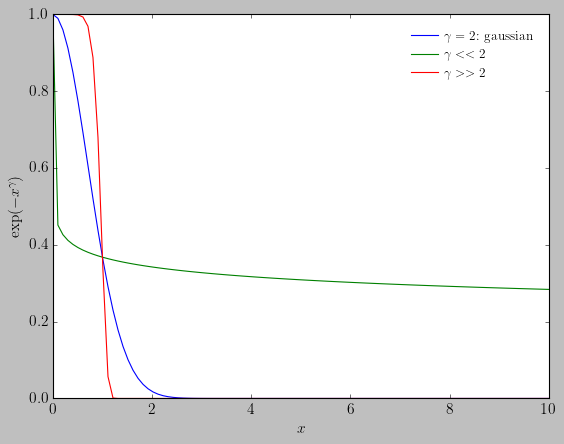

In [40]:
x = np.linspace(0,10,100)
y = np.exp(-x**2)
y1 = np.exp(-x**0.1)
y2 = np.exp(-x**10)
plt.plot(x,y,label='$\gamma = 2$: gaussian')
plt.plot(x,y1,label='$\gamma << 2$')
plt.plot(x,y2,label='$\gamma >> 2$')
plt.legend(numpoints=1, frameon=False)
plt.ylabel('exp$(-x^\gamma)$')
plt.xlabel('$x$')
plt.show()